# Flood Detection Methods

***
## Notes

 - Canny edge detection and morphological dilation buffer? Used [here](https://www.mdpi.com/2072-4292/8/5/386)
 - Read [this](https://developers.google.com/earth-engine/client_server) on GEE server vs. client sides

In [1]:
%matplotlib inline
import ipywidgets
import IPython.display
import numpy as np
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import ee; ee.Initialize()

# Configure the pretty printing output
pp = pprint.PrettyPrinter(depth=4)

## Otsu thresholding based on Donchyts et al. (2016), version 1

In [2]:
# Landsat 8 scene from Iowa City, IA (2016)
scene = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_025031_20160926')

# Calculate MNDWI
# This should eventually be done with a ML classifier if it's better - What did Dartmouth use? Ask Sam.

mndwi = scene.normalizedDifference(['B3','B7']).rename('mndwi') # L8, renamed 

def thresh(scene):
#     histogram = ndwi.reduceRegion(ee.Reducer.histogram(50).combine('mean', 'mean', True).combine('variance', 'var', True), polygon.buffer(1500), 100, None, None, True)
    histogram = scene.reduceRegion(ee.Reducer.histogram(50).combine('mean', None, True).combine('variance', None, True), None, 100, None, None, True)
    histogram = histogram.get('mndwi_histogram')

    def otsu(histogram):
        counts = ee.Array(ee.Dictionary(histogram).get('histogram'))
        means = ee.Array(ee.Dictionary(histogram).get('bucketMeans'))
        size = means.length().get([0])
        total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
        sums = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
        mean = sums.divide(total)
        indices = ee.List.sequence(1, size)
  
  ### Compute between sum of squares, where each mean partitions the data.
        def ss(i):
            aCounts = counts.slice(0, 0, i)
            aCount = aCounts.reduce(ee.Reducer.sum(), [0]).get([0]);
            aMeans = means.slice(0, 0, i);
            aMean = aMeans.multiply(aCounts).reduce(ee.Reducer.sum(), [0]).get([0]).divide(aCount)
            bCount = total.subtract(aCount)
            bMean = sums.subtract(aCount.multiply(aMean)).divide(bCount)
            return aCount.multiply(aMean.subtract(mean).pow(2)).add(bCount.multiply(bMean.subtract(mean).pow(2)))
        
        bss = indices.map(ss)
        return means.sort(bss).get([-1])

        #### Return the mean value corresponding to the maximum BSS.
    threshold = otsu(histogram)
#     return scene.addBands(ndwi).set({'threshold': threshold}) # threshold is a property of the ndwi band of this image, don't know how to get this computedobject though so we will just return the number itself for now
#     will eventually probs want to do the image thresholding on server side and not use getInfo, to speed up computation if need be
    return threshold # this is the otsu threshold

#============= With dilated MNDWI

# Canny edge detection
canny = ee.Algorithms.CannyEdgeDetector(mndwi, 0.99, 0)

# Now adding a buffer (morphological dilation) to the edges equal to 1/2 the pixel size (30m / 2  = 15m). 
# Might want to tune this parameter

# Define a kernel (structuring element)
kernel = ee.Kernel.square(radius = 1, units = 'pixels')

# Dilate
# buffered = canny.focal_max(kernel = kernel, iterations = 2)

buffered = mndwi.mask(canny.focal_max(30, 'square', 'meters'))


# Mask MNDWI
mndwi_mask = mndwi.mask(buffered)

threshold = thresh(mndwi_mask).getInfo()
threshold

# Threshold water from non-water
water = mndwi.gt(threshold)

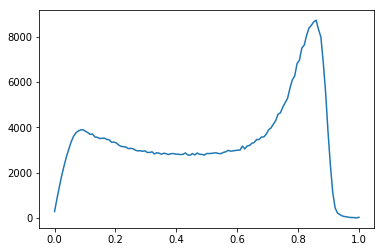

In [3]:
# Histogram just from buffer values

histogram = mndwi_mask.select('mndwi').reduceRegion(reducer = ee.Reducer.histogram(150), maxPixels=1e13).getInfo()
y = histogram['mndwi']['histogram'] 
x = [histogram['mndwi']['bucketWidth'] * v + histogram['mndwi']['bucketMin'] for v in range(len(y)) ]
plt.plot(x, y)

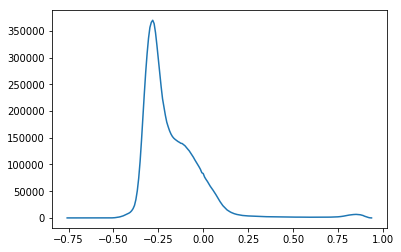

In [4]:
# #============= With entire MNDWI
scene_threshed = thresh(mndwi)
threshold = scene_threshed.getInfo()

url = mndwi.select('mndwi').lt(threshold).getThumbUrl()
# url = scene_threshed.select('mndwi').lt('threshold').getThumbUrl()
IPython.display.Image(url=url, format='png', embed=True)

histogram = mndwi.select('mndwi').reduceRegion(reducer = ee.Reducer.histogram(150), bestEffort=True).getInfo()
y = histogram['mndwi']['histogram'] 
x = [histogram['mndwi']['bucketWidth'] * v + histogram['mndwi']['bucketMin'] for v in range(len(y)) ]
plt.plot(x, y)

***
## Otsu thresholding based on Donchyts et al. (2016), version 2

In [27]:
# Landsat 8 scene from Iowa City, IA (2016)
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_025031_20160926')

# Copied from the notebook "Donchyts_cannyedge_NDWI_otsu"

%matplotlib inline

import urllib, io, os

from skimage import filters

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import seaborn as sns

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from shapely.geometry import mapping, shape

from IPython.display import Image, display

import ee


In [28]:
ee.Initialize()

In [29]:
# Landsat 8 scene from Iowa City, IA (2016)
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_025031_20160926')

In [30]:
# visualization functions

def get_path(image):
    return image.getThumbURL({'region' : geometry.getInfo(), 'format': 'png', 'dimensions': 1024})

def retrieve(image, path_out):
    path = get_path(image)
    
    if os.path.exists(path_out):
            os.remove(path_out)
    
    urllib.request.urlretrieve(path, path_out)

def show(image, path_out):
    plt.grid(False)
    
    if path_out:
        retrieve(image, path_out)
        plt.imshow(plt.imread(path_out))
    else:
        display(Image(url=get_path(image)))

In [31]:
water_bands = ['B3', 'B7'] # consider using B6 like Donchyts, compare?
removeShortEdges = False # ?
water_sigma = 1 # ?
water_threshold = 0.4 # ?
geometry = image.geometry()

### RGB

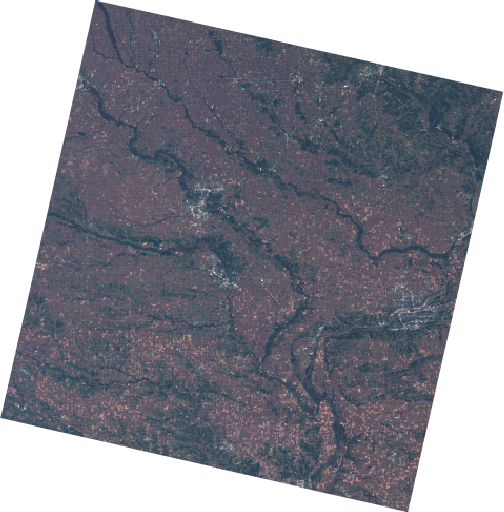

In [33]:
# visualize RGB
visparams = {'bands': 'B4,B3,B2', 
             'min': 0,
             'max': 0.25}

url = image.getThumbUrl(visparams) 
IPython.display.Image(url=url, format='png', embed=True)

### MNDWI

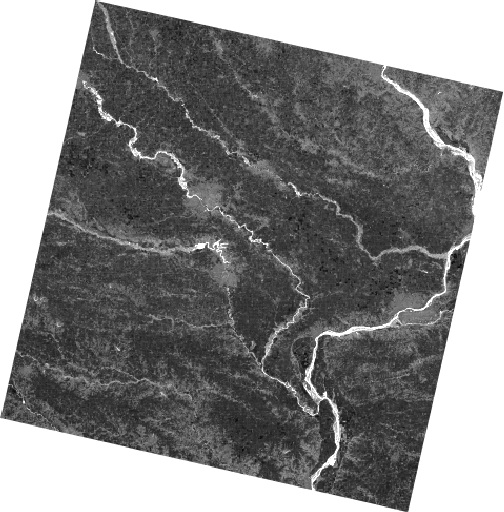

In [34]:
mndwi = image.normalizedDifference(water_bands)

visparams = {'min': -0.5,
             'max': 0.5}

url = mndwi.getThumbUrl(visparams) 
IPython.display.Image(url=url, format='png', embed=True)

Not sure if the MNDWI is catching all of the water, possibly because of turbidity. 

### Edge detection

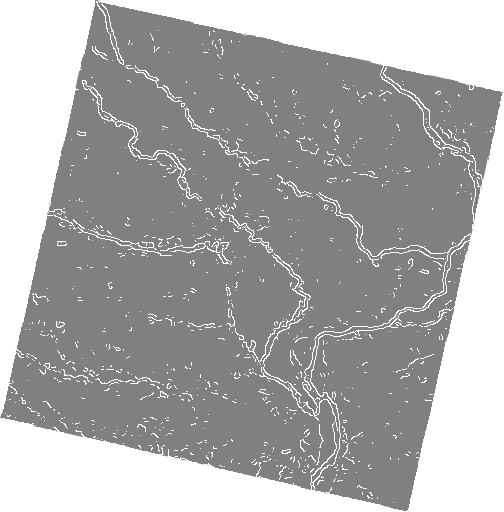

In [35]:
edge = ee.Algorithms.CannyEdgeDetector(mndwi, water_threshold, water_sigma)

# remove short edges
if removeShortEdges:
    connected = edge.mask(edge).lt(0.8).connectedPixelCount(35, True)
    edgeLong = connected.gte(35)
    edge = edgeLong
    
url = edge.getThumbUrl(visparams) 
IPython.display.Image(url=url, format='png', embed=True)

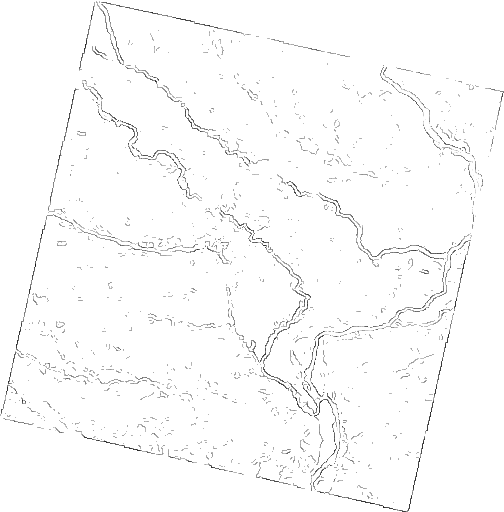

In [36]:
mndwi_buffer = mndwi.mask(edge.focal_max(60, 'square', 'meters'))

visparams = {'min': -0.5,
             'max': 0.5}

url = mndwi_buffer.getThumbUrl(visparams) 
IPython.display.Image(url=url, format='png', embed=True)

0.18016156601562494


(-1, 1)

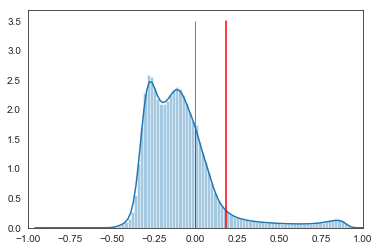

In [15]:
# local threshold

mndwi_buffer = mndwi.mask(edge.focal_max(30, 'square', 'meters'))

hist = mndwi_buffer.reduceRegion(ee.Reducer.histogram(150), geometry, 30, maxPixels = 1e13).getInfo()

values = mndwi_buffer.reduceRegion(ee.Reducer.toList(), geometry, 30, maxPixels = 1e13).getInfo() # why scale=15?

th = filters.threshold_otsu(np.array(values['nd']))
print(th)

sns.set_style('white')
f = plt.figure()
plt.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
sns.distplot(values['nd'], bins=100, kde_kws={'bw': 0.02})
plt.plot([th, th], [0, 3.5], 'r-')
plt.xlim(-1, 1)

In [16]:
# detect water
water = mndwi.gt(th) # water = values greater than the threshold
water_edge = ee.Algorithms.CannyEdgeDetector(water, 0.5, 0) # get the edge of the water

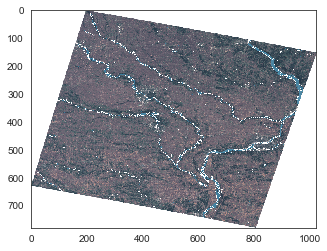

In [47]:
# Overlay mask on pansharpened RGB image

def panSharpenL8(scene):
    hsv = scene.select('B4', 'B3', 'B2').rgbToHsv()
    sharpened = ee.Image.cat([hsv.select('hue'), 
                              hsv.select('saturation'), 
                              image.select('B8')]).hsvToRgb()
    return sharpened

# parameters for stretching
visparams = {'min':0,
             'max': 0.25,
             'gamma': [1.3, 1.3, 1.3]}

sharpened = panSharpenL8(image)

im = ee.ImageCollection.fromImages([
#     image.visualize(**{'min':0.05, 'max':0.5, 'bands': ['B6', 'B5', 'B3']}),
#     image.visualize(**{'min':0.03, 'max':0.5, 'bands': ['B4', 'B3', 'B2']}),
    sharpened.visualize(**visparams),
    water.mask(water).visualize(**{'opacity':0.6, 'palette':['43a2ca']}),
    water_edge.mask(water_edge).visualize(**{'palette':['ffffff']}),
]).mosaic()

# im = water.mask(water).visualize(**{'opacity':0.6, 'palette':['43a2ca']})

show(im, 'water_final.png')
# url = im.getThumbUrl()
# IPython.display.Image(url=url, format='png', embed=True)

In [51]:
# Look at portion of image

poly = ee.Geometry.Polygon(
    [[[-91.78812019737575, 41.95033307316587],
           [-91.79361336143825, 41.90333364712244],
           [-91.71739571007106, 41.9012894084067],
           [-91.72151558311793, 41.95288639774597]]])

visparams = {'min':0,
             'max': 0.25,
             'gamma': [1.3, 1.3, 1.3],
             'region':poly}

im = ee.ImageCollection.fromImages([
#     image.visualize(**{'min':0.05, 'max':0.5, 'bands': ['B6', 'B5', 'B3']}),
#     image.visualize(**{'min':0.03, 'max':0.5, 'bands': ['B4', 'B3', 'B2']}),
    sharpened.visualize(**visparams),
    water.mask(water).visualize(**{'opacity':0.6, 'palette':['43a2ca']}),
    water_edge.mask(water_edge).visualize(**{'palette':['ffffff']}),
]).mosaic()

show(im, 'water_final.png')

EEException: Unrecognized arguments {'region'} to function: Produces an RGB or grayscale visualization of an image.  Each of the gain,
bias, min, max and gamma arguments can take either a single value, which
will be applied to all bands, or a list of values the same length as bands.

Args:
  image: The image to visualize.
  bands: A list of the bands to visualize.  If empty, the first 3
      are used.
  gain: The visualization gain(s) to use.
  bias: The visualization bias(es) to use.
  min: The value(s) to map to RGB8 value 0.
  max: The value(s) to map to RGB8 value 255.
  gamma: The gamma correction factor(s) to use.
  opacity: The opacity scaling factor to use.
  palette: The color palette to use. List of CSS color
      identifiers or hexadecimal color strings (e.g. ['red',
      '00FF00', 'bluevlolet']).
  forceRgbOutput: Whether to produce RGB output even for
      single-band inputs.

Otsu thresholding from the entire image takes too many values for EE to process

In [48]:
# Global threshold

# values = mndwi.reduceRegion(ee.Reducer.toList(), geometry, 30, maxPixels = 1e13).getInfo() # why scale=15?

# th = filters.threshold_otsu(np.array(values['nd']))
# print(th)

# sns.set_style('white')
# f = plt.figure()
# plt.plot([0, 0], [0, 3.5], 'k-', lw=0.5)
# sns.distplot(values['nd'], bins=100, kde_kws={'bw': 0.02})
# plt.plot([th, th], [0, 3.5], 'r-')
# plt.xlim(-1, 1)